## Data Preparation

data_fetcher.py

This module fetches historical stock
data from Yahoo Finance based on a list of symbols and saves it as CSV files for further use.

In [11]:
%%writefile data_fetcher.py


import yfinance as yf
import pandas as pd
import os

def fetch_and_save_stock_data(input_file, start_date="2010-01-01", end_date="2024-12-06", output_dir="enhancedata"):
    data = pd.read_csv(input_file)
    stock_symbols = data['Name'].unique()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for symbol in stock_symbols:
        try:
            print(f"Fetching data for {symbol}...")
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            if stock_data.empty:
                print(f"No data fetched for {symbol}, skipping.")
                continue
            file_path = os.path.join(output_dir, f"{symbol}.csv")
            stock_data.to_csv(file_path, mode='w')
            print(f"Saved data to {file_path}")
        except Exception as e:
            print(f"Failed to fetch data for {symbol}: {e}")



if __name__ == "__main__":
    # Example usage
    fetch_and_save_stock_data("all_stocks_5yr.csv")

def standardize_csv(input_dir="enhancedata"):
    """
    Standardize all CSV files in the specified directory.
    Removes invalid rows, resets index, and standardizes column names.
    """
    for file_name in os.listdir(input_dir):
        file_path = os.path.join(input_dir, file_name)
        if os.path.getsize(file_path) <= 2 * 1024:  # 2 KB
            print(f"Skipping {file_name} because its size is less than 2KB.")
            continue

        if file_name.endswith(".csv"):
            try:
                df = pd.read_csv(file_path)

                # Remove invalid rows and standardize column names
                df = df[~df.iloc[:, 0].isin(['Ticker', 'Date'])]
                df.reset_index(drop=True, inplace=True)
                df.columns = ['date', 'adj close', 'close', 'high', 'low', 'open', 'volume']

                df.to_csv(file_path, index=False)
                print(f"Processed and updated {file_name}.")
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")

Overwriting data_fetcher.py


data_preprocessor.py

This module preprocesses stock data by loading, normalizing, and splitting it into training and testing datasets, ready for machine learning models.

In [12]:
%%writefile data_preprocessor.py

import os
import pandas as pd
import numpy as np
import random

class StockEnhanceDataSet:
    def __init__(self, stock_sym, input_size=1, num_steps=30, test_ratio=0.1, normalized=True, close_price_only=True):
        self.stock_sym = stock_sym
        self.input_size = input_size
        self.num_steps = num_steps
        self.test_ratio = test_ratio
        self.close_price_only = close_price_only
        self.normalized = normalized

        # Reading CSV Files
        DATA_DIR = "enhancedata"
        file_path = os.path.join(DATA_DIR, f"{stock_sym}.csv")

        # Check if the file exists and is of the required size
        if not os.path.exists(file_path) or os.path.getsize(file_path) <= 2 * 1024:  # Files smaller than 2KB
            print(f"Skipping {stock_sym}: File too small or does not exist.")
            self.raw_seq = []
            self.train_X, self.train_y, self.test_X, self.test_y = [], [], [], []
            return

        raw_df = pd.read_csv(file_path)

        # Extract price series
        if close_price_only:
            self.raw_seq = raw_df['close'].dropna().tolist()
        else:
            self.raw_seq = [price for tup in raw_df[['open', 'close']].dropna().values for price in tup]

        self.raw_seq = np.array(self.raw_seq)
        if len(self.raw_seq) < self.num_steps:
            print(f"Skipping {stock_sym}: Not enough data for processing.")
            self.train_X, self.train_y, self.test_X, self.test_y = [], [], [], []
            return

        self.train_X, self.train_y, self.test_X, self.test_y = self._prepare_data(self.raw_seq)

    def info(self):
        if len(self.train_X) == 0 or len(self.test_X) == 0:
            return f"StockEnhanceDataSet [{self.stock_sym}] has insufficient data."
        return f"StockEnhanceDataSet [{self.stock_sym}] train: {len(self.train_X)} test: {len(self.test_y)}"

    def _prepare_data(self, seq):
        # Prepare data as a sequence of input size
        seq = [np.array(seq[i * self.input_size: (i + 1) * self.input_size]) for i in range(len(seq) // self.input_size)]

        if self.normalized:
            seq = [seq[0] / seq[0][0] - 1.0] + [curr / seq[i][-1] - 1.0 for i, curr in enumerate(seq[1:])]

        # Split into groups of time steps
        X = np.array([seq[i: i + self.num_steps] for i in range(len(seq) - self.num_steps)])
        y = np.array([seq[i + self.num_steps] for i in range(len(seq) - self.num_steps)])

        train_size = int(len(X) * (1.0 - self.test_ratio))
        train_X, test_X = X[:train_size], X[train_size:]
        train_y, test_y = y[:train_size], y[train_size:]
        return train_X, train_y, test_X, test_y



Overwriting data_preprocessor.py


Main Program

The main program orchestrates the workflow by fetching stock data using data_fetcher.py and preprocessing it with data_preprocessor.py.

In [ ]:
from data_fetcher import fetch_and_save_stock_data, standardize_csv
from data_preprocessor import StockEnhanceDataSet
import pandas as pd

def main():
    # Step 1: Fetch stock data
    input_file = "all_stocks_5yr.csv"
    fetch_and_save_stock_data(input_file)

    # Step 2: Standardize the fetched data
    standardize_csv()

    # Step 3: Preprocess and analyze standardized data
    symbols = pd.read_csv(input_file)['Name'].unique()
    print("Symbols to process:", symbols)
    for symbol in symbols:
        try:
            dataset = StockEnhanceDataSet(symbol)
            print(dataset.info())
        except Exception as e:
            print(f"Error processing symbol {symbol}: {e}")

if __name__ == "__main__":
    main()




Fetching data for AAL...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/AAL.csv
Fetching data for AAPL...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/AAPL.csv
Fetching data for AAP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AAP.csv
Fetching data for ABBV...


Saved data to enhancedata/ABBV.csv
Fetching data for ABC...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ABC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for ABC, skipping.
Fetching data for ABT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ABT.csv
Fetching data for ACN...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ACN.csv
Fetching data for ADBE...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ADBE.csv
Fetching data for ADI...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ADI.csv
Fetching data for ADM...


Saved data to enhancedata/ADM.csv
Fetching data for ADP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ADP.csv
Fetching data for ADSK...
Saved data to enhancedata/ADSK.csv
Fetching data for ADS...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ADS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for ADS, skipping.
Fetching data for AEE...
Saved data to enhancedata/AEE.csv
Fetching data for AEP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/AEP.csv
Fetching data for AES...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AES.csv
Fetching data for AET...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AET.csv
Fetching data for AFL...


Saved data to enhancedata/AFL.csv
Fetching data for AGN...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AGN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for AGN, skipping.
Fetching data for AIG...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/AIG.csv
Fetching data for AIV...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AIV.csv
Fetching data for AIZ...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AIZ.csv
Fetching data for AJG...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/AJG.csv
Fetching data for AKAM...
Saved data to enhancedata/AKAM.csv
Fetching data for ALB...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ALB.csv
Fetching data for ALGN...
Saved data to enhancedata/ALGN.csv
Fetching data for ALK...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ALK.csv
Fetching data for ALLE...
Saved data to enhancedata/ALLE.csv
Fetching data for ALL...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ALL.csv
Fetching data for ALXN...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ALXN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

No data fetched for ALXN, skipping.
Fetching data for AMAT...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/AMAT.csv
Fetching data for AMD...
Saved data to enhancedata/AMD.csv
Fetching data for AME...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AME.csv
Fetching data for AMGN...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AMGN.csv
Fetching data for AMG...


Saved data to enhancedata/AMG.csv
Fetching data for AMP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AMP.csv
Fetching data for AMT...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/AMT.csv
Fetching data for AMZN...
Saved data to enhancedata/AMZN.csv
Fetching data for ANDV...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ANDV.csv
Fetching data for ANSS...
Saved data to enhancedata/ANSS.csv
Fetching data for ANTM...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ANTM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for ANTM, skipping.
Fetching data for AON...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/AON.csv
Fetching data for AOS...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/AOS.csv
Fetching data for APA...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/APA.csv
Fetching data for APC...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['APC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for APC, skipping.
Fetching data for APD...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/APD.csv
Fetching data for APH...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/APH.csv
Fetching data for APTV...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/APTV.csv
Fetching data for ARE...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ARE.csv
Fetching data for ARNC...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ARNC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for ARNC, skipping.
Fetching data for ATVI...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for ATVI, skipping.
Fetching data for AVB...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AVB.csv
Fetching data for AVGO...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AVGO.csv
Fetching data for AVY...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AVY.csv
Fetching data for AWK...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AWK.csv
Fetching data for AXP...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/AXP.csv
Fetching data for AYI...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/AYI.csv
Fetching data for AZO...
Saved data to enhancedata/AZO.csv
Fetching data for A...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/A.csv
Fetching data for BAC...


Saved data to enhancedata/BAC.csv
Fetching data for BAX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/BAX.csv
Fetching data for BA...


Saved data to enhancedata/BA.csv
Fetching data for BBT...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BBT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for BBT, skipping.
Fetching data for BBY...
Saved data to enhancedata/BBY.csv
Fetching data for BDX...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/BDX.csv
Fetching data for BEN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-06)')
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/BEN.csv
Fetching data for BF.B...
No data fetched for BF.B, skipping.
Fetching data for BHF...


Saved data to enhancedata/BHF.csv
Fetching data for BHGE...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BHGE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for BHGE, skipping.
Fetching data for BIIB...
Saved data to enhancedata/BIIB.csv
Fetching data for BK...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/BK.csv
Fetching data for BLK...


Saved data to enhancedata/BLK.csv
Fetching data for BLL...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BLL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for BLL, skipping.
Fetching data for BMY...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/BMY.csv
Fetching data for BRK.B...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for BRK.B, skipping.
Fetching data for BSX...
Saved data to enhancedata/BSX.csv
Fetching data for BWA...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/BWA.csv
Fetching data for BXP...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/BXP.csv
Fetching data for CAG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/CAG.csv
Fetching data for CAH...


Saved data to enhancedata/CAH.csv
Fetching data for CAT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CBG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-06)')


Saved data to enhancedata/CAT.csv
Fetching data for CA...
Saved data to enhancedata/CA.csv
Fetching data for CBG...
No data fetched for CBG, skipping.
Fetching data for CBOE...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CBOE.csv
Fetching data for CBS...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CBS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for CBS, skipping.
Fetching data for CB...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CB.csv
Fetching data for CCI...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CCI.csv
Fetching data for CCL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/CCL.csv
Fetching data for CDNS...


Saved data to enhancedata/CDNS.csv
Fetching data for CELG...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CELG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for CELG, skipping.
Fetching data for CERN...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CERN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for CERN, skipping.
Fetching data for CFG...
Saved data to enhancedata/CFG.csv
Fetching data for CF...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/CF.csv
Fetching data for CHD...


Saved data to enhancedata/CHD.csv
Fetching data for CHK...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CHK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for CHK, skipping.
Fetching data for CHRW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CHRW.csv
Fetching data for CHTR...
Saved data to enhancedata/CHTR.csv
Fetching data for CINF...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CINF.csv
Fetching data for CI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/CI.csv
Fetching data for CLX...


Saved data to enhancedata/CLX.csv
Fetching data for CL...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CL.csv
Fetching data for CMA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/CMA.csv
Fetching data for CMCSA...


Saved data to enhancedata/CMCSA.csv
Fetching data for CME...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/CME.csv
Fetching data for CMG...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/CMG.csv
Fetching data for CMI...


Saved data to enhancedata/CMI.csv
Fetching data for CMS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CMS.csv
Fetching data for CNC...
Saved data to enhancedata/CNC.csv
Fetching data for CNP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CNP.csv
Fetching data for COF...
Saved data to enhancedata/COF.csv
Fetching data for COG...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['COG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for COG, skipping.
Fetching data for COL...
Saved data to enhancedata/COL.csv
Fetching data for COO...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/COO.csv
Fetching data for COP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/COP.csv
Fetching data for COST...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/COST.csv
Fetching data for COTY...
Saved data to enhancedata/COTY.csv
Fetching data for CPB...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CPB.csv
Fetching data for CRM...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CRM.csv
Fetching data for CSCO...
Saved data to enhancedata/CSCO.csv
Fetching data for CSRA...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CSRA.csv
Fetching data for CSX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/CSX.csv
Fetching data for CTAS...


Saved data to enhancedata/CTAS.csv
Fetching data for CTL...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CTL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for CTL, skipping.
Fetching data for CTSH...
Saved data to enhancedata/CTSH.csv
Fetching data for CTXS...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CTXS']: possibly delisted; no timezone found
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CTXS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for CTXS, skipping.
Fetching data for CVS...
No data fetched for CVS, skipping.
Fetching data for CVX...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/CVX.csv
Fetching data for CXO...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CXO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for CXO, skipping.
Fetching data for C...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/C.csv
Fetching data for DAL...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/DAL.csv
Fetching data for DE...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/DE.csv
Fetching data for DFS...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/DFS.csv
Fetching data for DGX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/DGX.csv
Fetching data for DG...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/DG.csv
Fetching data for DHI...


Saved data to enhancedata/DHI.csv
Fetching data for DHR...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/DHR.csv
Fetching data for DISCA...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DISCA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for DISCA, skipping.
Fetching data for DISCK...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DISCK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for DISCK, skipping.
Fetching data for DISH...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DISH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for DISH, skipping.
Fetching data for DIS...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/DIS.csv
Fetching data for DLR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/DLR.csv
Fetching data for DLTR...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/DLTR.csv
Fetching data for DOV...



[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DPS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-06)')


Saved data to enhancedata/DOV.csv
Fetching data for DPS...
No data fetched for DPS, skipping.
Fetching data for DRE...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DRE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for DRE, skipping.
Fetching data for DRI...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/DRI.csv
Fetching data for DTE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/DTE.csv
Fetching data for DUK...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/DUK.csv
Fetching data for DVA...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/DVA.csv
Fetching data for DVN...


Saved data to enhancedata/DVN.csv
Fetching data for DWDP...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DWDP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for DWDP, skipping.
Fetching data for DXC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/DXC.csv
Fetching data for D...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/D.csv
Fetching data for EA...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/EA.csv
Fetching data for EBAY...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/EBAY.csv
Fetching data for ECL...


Saved data to enhancedata/ECL.csv
Fetching data for ED...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ED.csv
Fetching data for EFX...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/EFX.csv
Fetching data for EIX...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/EIX.csv
Fetching data for EL...


Saved data to enhancedata/EL.csv
Fetching data for EMN...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/EMN.csv
Fetching data for EMR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/EMR.csv
Fetching data for EOG...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/EOG.csv
Fetching data for EQIX...
Saved data to enhancedata/EQIX.csv
Fetching data for EQR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/EQR.csv
Fetching data for EQT...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/EQT.csv
Fetching data for ESRX...
Saved data to enhancedata/ESRX.csv
Fetching data for ESS...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ESS.csv
Fetching data for ES...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ES.csv
Fetching data for ETFC...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ETFC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for ETFC, skipping.
Fetching data for ETN...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ETN.csv
Fetching data for ETR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ETR.csv
Fetching data for EVHC...
Saved data to enhancedata/EVHC.csv
Fetching data for EW...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/EW.csv
Fetching data for EXC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/EXC.csv
Fetching data for EXPD...


Saved data to enhancedata/EXPD.csv
Fetching data for EXPE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/EXPE.csv
Fetching data for EXR...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/EXR.csv
Fetching data for FAST...


Saved data to enhancedata/FAST.csv
Fetching data for FBHS...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FBHS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for FBHS, skipping.
Fetching data for FB...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

No data fetched for FB, skipping.
Fetching data for FCX...


Saved data to enhancedata/FCX.csv
Fetching data for FDX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/FDX.csv
Fetching data for FE...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/FE.csv
Fetching data for FFIV...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/FFIV.csv
Fetching data for FISV...
Saved data to enhancedata/FISV.csv
Fetching data for FIS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/FIS.csv
Fetching data for FITB...


Saved data to enhancedata/FITB.csv
Fetching data for FLIR...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FLIR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for FLIR, skipping.
Fetching data for FLR...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/FLR.csv
Fetching data for FLS...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/FLS.csv
Fetching data for FL...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/FL.csv
Fetching data for FMC...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/FMC.csv
Fetching data for FOXA...
Saved data to enhancedata/FOXA.csv
Fetching data for FOX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/FOX.csv
Fetching data for FRT...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/FRT.csv
Fetching data for FTI...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/FTI.csv
Fetching data for FTV...


Saved data to enhancedata/FTV.csv
Fetching data for F...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/F.csv
Fetching data for GD...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/GD.csv
Fetching data for GE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GGP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-06)')


Saved data to enhancedata/GE.csv
Fetching data for GGP...
No data fetched for GGP, skipping.
Fetching data for GILD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/GILD.csv
Fetching data for GIS...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/GIS.csv
Fetching data for GLW...


Saved data to enhancedata/GLW.csv
Fetching data for GM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/GM.csv
Fetching data for GOOGL...


Saved data to enhancedata/GOOGL.csv
Fetching data for GOOG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/GOOG.csv
Fetching data for GPC...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/GPC.csv
Fetching data for GPN...


Saved data to enhancedata/GPN.csv
Fetching data for GPS...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GPS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for GPS, skipping.
Fetching data for GRMN...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/GRMN.csv
Fetching data for GS...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/GS.csv
Fetching data for GT...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/GT.csv
Fetching data for GWW...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/GWW.csv
Fetching data for HAL...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/HAL.csv
Fetching data for HAS...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/HAS.csv
Fetching data for HBAN...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/HBAN.csv
Fetching data for HBI...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/HBI.csv
Fetching data for HCA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HCN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-06)')
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HCA.csv
Fetching data for HCN...
No data fetched for HCN, skipping.
Fetching data for HCP...
Saved data to enhancedata/HCP.csv
Fetching data for HD...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HD.csv
Fetching data for HES...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HES.csv
Fetching data for HIG...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HIG.csv
Fetching data for HII...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HII.csv
Fetching data for HLT...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HLT.csv
Fetching data for HOG...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HOG.csv
Fetching data for HOLX...


Saved data to enhancedata/HOLX.csv
Fetching data for HON...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/HON.csv
Fetching data for HPE...
Saved data to enhancedata/HPE.csv
Fetching data for HPQ...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HPQ.csv
Fetching data for HP...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HP.csv
Fetching data for HRB...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HRB.csv
Fetching data for HRL...


Saved data to enhancedata/HRL.csv
Fetching data for HRS...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HRS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for HRS, skipping.
Fetching data for HSIC...
Saved data to enhancedata/HSIC.csv

[*********************100%***********************]  1 of 1 completed


Fetching data for HST...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/HST.csv
Fetching data for HSY...


Saved data to enhancedata/HSY.csv
Fetching data for HUM...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/HUM.csv
Fetching data for IBM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/IBM.csv
Fetching data for ICE...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ICE.csv
Fetching data for IDXX...
Saved data to enhancedata/IDXX.csv
Fetching data for IFF...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/IFF.csv
Fetching data for ILMN...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ILMN.csv
Fetching data for INCY...
Saved data to enhancedata/INCY.csv
Fetching data for INFO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/INFO.csv
Fetching data for INTC...
Saved data to enhancedata/INTC.csv
Fetching data for INTU...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/INTU.csv
Fetching data for IPG...


Saved data to enhancedata/IPG.csv
Fetching data for IP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/IP.csv
Fetching data for IQV...
Saved data to enhancedata/IQV.csv
Fetching data for IRM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/IRM.csv
Fetching data for IR...
Saved data to enhancedata/IR.csv
Fetching data for ISRG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ISRG.csv
Fetching data for ITW...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/ITW.csv
Fetching data for IT...
Saved data to enhancedata/IT.csv
Fetching data for IVZ...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/IVZ.csv
Fetching data for JBHT...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/JBHT.csv
Fetching data for JCI...


Saved data to enhancedata/JCI.csv
Fetching data for JEC...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JEC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for JEC, skipping.
Fetching data for JNJ...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/JNJ.csv
Fetching data for JNPR...


Saved data to enhancedata/JNPR.csv
Fetching data for JPM...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/JPM.csv
Fetching data for JWN...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/JWN.csv
Fetching data for KEY...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/KEY.csv
Fetching data for KHC...


Saved data to enhancedata/KHC.csv
Fetching data for KIM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/KIM.csv
Fetching data for KLAC...


Saved data to enhancedata/KLAC.csv
Fetching data for KMB...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/KMB.csv
Fetching data for KMI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/KMI.csv
Fetching data for KMX...



[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KORS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-06)')


Saved data to enhancedata/KMX.csv
Fetching data for KORS...
No data fetched for KORS, skipping.
Fetching data for KO...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/KO.csv
Fetching data for KR...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/KR.csv
Fetching data for KSS...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/KSS.csv
Fetching data for KSU...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KSU']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for KSU, skipping.
Fetching data for K...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/K.csv
Fetching data for LB...
Saved data to enhancedata/LB.csv
Fetching data for LEG...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/LEG.csv
Fetching data for LEN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/LEN.csv
Fetching data for LH...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/LH.csv
Fetching data for LKQ...


Saved data to enhancedata/LKQ.csv
Fetching data for LLL...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LLL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for LLL, skipping.
Fetching data for LLY...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/LLY.csv
Fetching data for LMT...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/LMT.csv
Fetching data for LNC...


Saved data to enhancedata/LNC.csv
Fetching data for LNT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/LNT.csv
Fetching data for LOW...


Saved data to enhancedata/LOW.csv
Fetching data for LRCX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LUK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-06)')


Saved data to enhancedata/LRCX.csv
Fetching data for LUK...
No data fetched for LUK, skipping.
Fetching data for LUV...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/LUV.csv
Fetching data for LYB...


Saved data to enhancedata/LYB.csv
Fetching data for L...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/L.csv
Fetching data for MAA...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MAA.csv
Fetching data for MAC...


Saved data to enhancedata/MAC.csv
Fetching data for MAR...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/MAR.csv
Fetching data for MAS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MAS.csv
Fetching data for MAT...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MAT.csv
Fetching data for MA...


Saved data to enhancedata/MA.csv
Fetching data for MCD...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/MCD.csv
Fetching data for MCHP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MCHP.csv
Fetching data for MCK...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MCK.csv
Fetching data for MCO...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MCO.csv
Fetching data for MDLZ...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MDLZ.csv
Fetching data for MDT...


Saved data to enhancedata/MDT.csv
Fetching data for MET...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MET.csv
Fetching data for MGM...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MGM.csv
Fetching data for MHK...
Saved data to enhancedata/MHK.csv
Fetching data for MKC...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MKC.csv
Fetching data for MLM...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MLM.csv
Fetching data for MMC...


Saved data to enhancedata/MMC.csv
Fetching data for MMM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MMM.csv
Fetching data for MNST...


Saved data to enhancedata/MNST.csv
Fetching data for MON...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MON']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for MON, skipping.
Fetching data for MOS...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/MOS.csv
Fetching data for MO...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/MO.csv
Fetching data for MPC...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/MPC.csv
Fetching data for MRK...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/MRK.csv
Fetching data for MRO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MRO.csv
Fetching data for MSFT...


Saved data to enhancedata/MSFT.csv
Fetching data for MSI...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/MSI.csv
Fetching data for MS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/MS.csv
Fetching data for MTB...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/MTB.csv
Fetching data for MTD...
Saved data to enhancedata/MTD.csv
Fetching data for MU...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/MU.csv
Fetching data for MYL...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MYL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for MYL, skipping.
Fetching data for M...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/M.csv
Fetching data for NAVI...
Saved data to enhancedata/NAVI.csv
Fetching data for NBL...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NBL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for NBL, skipping.
Fetching data for NCLH...
Saved data to enhancedata/NCLH.csv
Fetching data for NDAQ...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/NDAQ.csv
Fetching data for NEE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/NEE.csv
Fetching data for NEM...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/NEM.csv
Fetching data for NFLX...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/NFLX.csv
Fetching data for NFX...
Saved data to enhancedata/NFX.csv
Fetching data for NI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/NI.csv
Fetching data for NKE...


Saved data to enhancedata/NKE.csv
Fetching data for NLSN...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NLSN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for NLSN, skipping.
Fetching data for NOC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/NOC.csv
Fetching data for NOV...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/NOV.csv
Fetching data for NRG...
Saved data to enhancedata/NRG.csv
Fetching data for NSC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/NSC.csv
Fetching data for NTAP...


Saved data to enhancedata/NTAP.csv
Fetching data for NTRS...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/NTRS.csv
Fetching data for NUE...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/NUE.csv
Fetching data for NVDA...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/NVDA.csv
Fetching data for NWL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/NWL.csv
Fetching data for NWSA...
Saved data to enhancedata/NWSA.csv
Fetching data for NWS...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/NWS.csv
Fetching data for OKE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/OKE.csv
Fetching data for OMC...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/OMC.csv
Fetching data for ORCL...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ORCL.csv
Fetching data for ORLY...


Saved data to enhancedata/ORLY.csv
Fetching data for OXY...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/OXY.csv
Fetching data for O...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/O.csv
Fetching data for PAYX...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/PAYX.csv
Fetching data for PBCT...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PBCT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for PBCT, skipping.
Fetching data for PCAR...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/PCAR.csv
Fetching data for PCG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PCLN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-06)')


Saved data to enhancedata/PCG.csv
Fetching data for PCLN...
No data fetched for PCLN, skipping.
Fetching data for PDCO...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/PDCO.csv
Fetching data for PEG...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/PEG.csv
Fetching data for PEP...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/PEP.csv
Fetching data for PFE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/PFE.csv
Fetching data for PFG...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/PFG.csv
Fetching data for PGR...


Saved data to enhancedata/PGR.csv
Fetching data for PG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/PG.csv
Fetching data for PHM...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/PHM.csv
Fetching data for PH...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/PH.csv
Fetching data for PKG...


Saved data to enhancedata/PKG.csv
Fetching data for PKI...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PKI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for PKI, skipping.
Fetching data for PLD...
Saved data to enhancedata/PLD.csv
Fetching data for PM...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/PM.csv
Fetching data for PNC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/PNC.csv
Fetching data for PNR...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/PNR.csv
Fetching data for PNW...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/PNW.csv
Fetching data for PPG...


Saved data to enhancedata/PPG.csv
Fetching data for PPL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/PPL.csv
Fetching data for PRGO...
Saved data to enhancedata/PRGO.csv
Fetching data for PRU...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/PRU.csv
Fetching data for PSA...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/PSA.csv
Fetching data for PSX...
Saved data to enhancedata/PSX.csv
Fetching data for PVH...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/PVH.csv
Fetching data for PWR...
Saved data to enhancedata/PWR.csv
Fetching data for PXD...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PXD']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for PXD, skipping.
Fetching data for PX...
Saved data to enhancedata/PX.csv
Fetching data for PYPL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/PYPL.csv
Fetching data for QCOM...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/QCOM.csv
Fetching data for QRVO...
Saved data to enhancedata/QRVO.csv
Fetching data for RCL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/RCL.csv
Fetching data for REGN...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/REGN.csv
Fetching data for REG...


Saved data to enhancedata/REG.csv
Fetching data for RE...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for RE, skipping.
Fetching data for RF...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/RF.csv
Fetching data for RHI...


Saved data to enhancedata/RHI.csv
Fetching data for RHT...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RHT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for RHT, skipping.
Fetching data for RJF...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/RJF.csv
Fetching data for RL...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/RL.csv
Fetching data for RMD...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/RMD.csv
Fetching data for ROK...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ROK.csv
Fetching data for ROP...


Saved data to enhancedata/ROP.csv
Fetching data for ROST...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ROST.csv
Fetching data for RRC...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/RRC.csv
Fetching data for RSG...


Saved data to enhancedata/RSG.csv
Fetching data for RTN...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RTN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

No data fetched for RTN, skipping.
Fetching data for SBAC...


Saved data to enhancedata/SBAC.csv
Fetching data for SBUX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/SBUX.csv
Fetching data for SCG...
Saved data to enhancedata/SCG.csv
Fetching data for SCHW...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/SCHW.csv
Fetching data for SEE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/SEE.csv
Fetching data for SHW...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/SHW.csv
Fetching data for SIG...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/SIG.csv
Fetching data for SJM...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/SJM.csv
Fetching data for SLB...


Saved data to enhancedata/SLB.csv
Fetching data for SLG...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/SLG.csv
Fetching data for SNA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/SNA.csv
Fetching data for SNI...
Saved data to enhancedata/SNI.csv
Fetching data for SNPS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/SNPS.csv
Fetching data for SO...


Saved data to enhancedata/SO.csv
Fetching data for SPGI...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/SPGI.csv
Fetching data for SPG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/SPG.csv
Fetching data for SRCL...
Saved data to enhancedata/SRCL.csv
Fetching data for SRE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/SRE.csv
Fetching data for STI...
Saved data to enhancedata/STI.csv
Fetching data for STT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/STT.csv
Fetching data for STX...


Saved data to enhancedata/STX.csv
Fetching data for STZ...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/STZ.csv
Fetching data for SWKS...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/SWKS.csv
Fetching data for SWK...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/SWK.csv
Fetching data for SYF...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/SYF.csv
Fetching data for SYK...


Saved data to enhancedata/SYK.csv
Fetching data for SYMC...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SYMC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for SYMC, skipping.
Fetching data for SYY...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/SYY.csv
Fetching data for TAP...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/TAP.csv
Fetching data for TDG...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/TDG.csv
Fetching data for TEL...
Saved data to enhancedata/TEL.csv
Fetching data for TGT...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/TGT.csv
Fetching data for TIF...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TIF']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for TIF, skipping.
Fetching data for TJX...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/TJX.csv
Fetching data for TMK...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TMK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for TMK, skipping.
Fetching data for TMO...


[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/TMO.csv
Fetching data for TPR...
Saved data to enhancedata/TPR.csv
Fetching data for TRIP...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/TRIP.csv
Fetching data for TROW...


Saved data to enhancedata/TROW.csv
Fetching data for TRV...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/TRV.csv
Fetching data for TSCO...


Saved data to enhancedata/TSCO.csv
Fetching data for TSN...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/TSN.csv
Fetching data for TSS...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data fetched for TSS, skipping.
Fetching data for TWX...
Saved data to enhancedata/TWX.csv
Fetching data for TXN...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/TXN.csv
Fetching data for TXT...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/TXT.csv
Fetching data for T...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/T.csv
Fetching data for UAA...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/UAA.csv
Fetching data for UAL...
Saved data to enhancedata/UAL.csv
Fetching data for UA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/UA.csv
Fetching data for UDR...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/UDR.csv
Fetching data for UHS...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/UHS.csv
Fetching data for ULTA...


Saved data to enhancedata/ULTA.csv
Fetching data for UNH...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/UNH.csv
Fetching data for UNM...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/UNM.csv
Fetching data for UNP...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/UNP.csv
Fetching data for UPS...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/UPS.csv
Fetching data for URI...


Saved data to enhancedata/URI.csv
Fetching data for USB...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/USB.csv
Fetching data for UTX...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['UTX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for UTX, skipping.
Fetching data for VAR...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VAR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for VAR, skipping.
Fetching data for VFC...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/VFC.csv
Fetching data for VIAB...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VIAB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for VIAB, skipping.
Fetching data for VLO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/VLO.csv
Fetching data for VMC...


Saved data to enhancedata/VMC.csv
Fetching data for VNO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/VNO.csv
Fetching data for VRSK...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/VRSK.csv
Fetching data for VRSN...



[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/VRSN.csv
Fetching data for VRTX...
Saved data to enhancedata/VRTX.csv
Fetching data for VTR...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/VTR.csv
Fetching data for VZ...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/VZ.csv
Fetching data for V...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/V.csv
Fetching data for WAT...
Saved data to enhancedata/WAT.csv
Fetching data for WBA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/WBA.csv
Fetching data for WDC...
Saved data to enhancedata/WDC.csv
Fetching data for WEC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/WEC.csv
Fetching data for WFC...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/WFC.csv
Fetching data for WHR...


Saved data to enhancedata/WHR.csv
Fetching data for WLTW...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WLTW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for WLTW, skipping.
Fetching data for WMB...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/WMB.csv
Fetching data for WMT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/WMT.csv
Fetching data for WM...


Saved data to enhancedata/WM.csv
Fetching data for WRK...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WRK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

No data fetched for WRK, skipping.
Fetching data for WU...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/WU.csv
Fetching data for WYNN...



[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WYN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-06)')


Saved data to enhancedata/WYNN.csv
Fetching data for WYN...
No data fetched for WYN, skipping.
Fetching data for WY...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/WY.csv
Fetching data for XEC...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['XEC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for XEC, skipping.
Fetching data for XEL...


[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/XEL.csv
Fetching data for XLNX...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['XLNX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for XLNX, skipping.
Fetching data for XL...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['XL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data fetched for XL, skipping.
Fetching data for XOM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/XOM.csv
Fetching data for XRAY...


Saved data to enhancedata/XRAY.csv
Fetching data for XRX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to enhancedata/XRX.csv
Fetching data for XYL...
Saved data to enhancedata/XYL.csv
Fetching data for YUM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/YUM.csv
Fetching data for ZBH...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ZBH.csv
Fetching data for ZION...



[*********************100%***********************]  1 of 1 completed

Saved data to enhancedata/ZION.csv
Fetching data for ZTS...
Saved data to enhancedata/ZTS.csv


Processed and updated ADP.csv.
Processed and updated INCY.csv.
Processed and updated VZ.csv.
Processed and updated HII.csv.
Processed and updated WBA.csv.
Processed and updated GPN.csv.
Processed and updated KLAC.csv.
Processed and updated ALK.csv.
Processed and updated LYB.csv.
Processed and updated AVY.csv.
Processed and updated KEY.csv.
Processed and updated AME.csv.
Processed and updated ULTA.csv.
Processed and updated SIG.csv.
Processed and updated TSN.csv.
Processed and updated ISRG.csv.
Processed and updated STZ.csv.
Processed and updated COL.csv.
Processed and updated ABBV.csv.
Processed and updated BAX.csv.
Processed and updated NCLH.csv.
Processed and updated COO.csv.
Processed and updated SLG.csv.
Processed and updated SPG.csv.
Processed and updated AMT.csv.
Processed and updated MNST.csv.
Processed and updated NOC.csv.
Processed and updated ARE.csv.
Processed and updated PGR.csv.
Processed and updated PKG.csv.
Processed and updated UDR.csv.
Processed and updated HRB.csv.
Pr

# LSTM

In [21]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error



class LstmRNNEh:
    def __init__(self, stock_count, lstm_size=128, num_layers=1, num_steps=30, input_size=1,
                 dropout_rate=0.2, logs_dir="logs", plots_dir="images", model_type="LSTM"):
        """
        Construct a RNN model using LSTM or other architectures.

        Args:
            stock_count: Number of stocks being processed
            lstm_size: Number of units in LSTM layers
            num_layers: Number of stacked layers
            num_steps: Number of time steps in the input sequence
            input_size: Number of features in each input step
            dropout_rate: Dropout rate to prevent overfitting
            logs_dir: Directory to save logs
            plots_dir: Directory to save plots
            model_type: Type of model to use ("LSTM", "Bidirectional_LSTM")
        """
        self.stock_count = stock_count
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.num_steps = num_steps
        self.input_size = input_size
        self.dropout_rate = dropout_rate
        self.logs_dir = logs_dir
        self.plots_dir = plots_dir
        self.model_type = model_type

        # Build the model based on the specified architecture
        self.model = self.build_model()

    def build_model(self):
        """
        Build the model based on the specified type: LSTM, Bidirectional LSTM
        """
        model = Sequential()

        # Adding an Input layer
        model.add(Input(shape=(self.num_steps, self.input_size)))

        if self.model_type == "LSTM":
            for i in range(self.num_layers):
                return_sequences = i < self.num_layers - 1  # True if not the last layer
                model.add(LSTM(units=self.lstm_size, return_sequences=return_sequences))
                model.add(Dropout(self.dropout_rate))

        elif self.model_type == "Bidirectional_LSTM":
            for i in range(self.num_layers):
                return_sequences = i < self.num_layers - 1
                model.add(Bidirectional(LSTM(units=self.lstm_size, return_sequences=return_sequences)))
                model.add(Dropout(self.dropout_rate))

            model.add(Flatten())  # Flatten the output for the Dense layer

        # Add the output layer
        model.add(Dense(units=self.input_size))
        model.compile(optimizer="adam", loss="mean_squared_error")

        return model

    def train(self, dataset_list, config):
        """
        Train the model with the given dataset.
        Implement cross-validation during training.

        Args:
            dataset_list: List of StockDataSet objects
            config: Configuration settings (e.g., max_epoch, batch_size)
        """
        assert len(dataset_list) > 0, "Dataset list is empty."

        merged_train_X = []
        merged_train_y = []
        for dataset in dataset_list:
            merged_train_X.append(dataset.train_X)
            merged_train_y.append(dataset.train_y)

        train_X = np.concatenate(merged_train_X, axis=0)
        train_y = np.concatenate(merged_train_y, axis=0)

        # Implement Cross-Validation
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        fold_no = 1

        for train_idx, val_idx in kfold.split(train_X, train_y):
            print(f"Training fold {fold_no}...")
            fold_train_X, fold_val_X = train_X[train_idx], train_X[val_idx]
            fold_train_y, fold_val_y = train_y[train_idx], train_y[val_idx]

            # Train the model on the current fold
            self.model.fit(
                fold_train_X, fold_train_y,
                epochs=config['max_epoch'],
                batch_size=config['batch_size'],
                validation_data=(fold_val_X, fold_val_y),
                verbose=2
            )

            fold_no += 1

    def predict(self, dataset):
        """
        Predict using the trained model.

        Args:
            dataset: A StockDataSet object containing test data.

        Returns:
            np.array: Predicted values.
        """
        predictions = self.model.predict(dataset.test_X)
        return predictions

    def evaluate(self, dataset):
        """
        Evaluate the model on the test dataset.

        Args:
            dataset: A StockDataSet object containing test data

        Returns:
            Test loss
        """
        test_loss = self.model.evaluate(dataset.test_X, dataset.test_y, verbose=2)
        print(f"Test Loss: {test_loss}")
        return test_loss

    def save(self):
        """
        Save the trained model.
        """
        model_path = os.path.join(self.logs_dir, "lstm_model_enhance.h5")
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

    def load(self):
        """
        Load the trained model.
        """
        model_path = os.path.join(self.logs_dir, "lstm_model_enhance.h5")
        if os.path.exists(model_path):
            self.model = tf.keras.models.load_model(model_path)
            print(f"Model loaded from {model_path}")
        else:
            print(f"No model found at {model_path}")

    def plot_samples(self, preds, targets, stock_sym=None):
        """
        Plot predictions vs ground truth.

        Args:
            preds: Predicted values
            targets: Ground truth values
            stock_sym: Stock symbol for the plot title
        """
        days = np.arange(len(targets))

        plt.figure(figsize=(12, 6))
        plt.plot(days, targets, label='True Prices', color='blue')
        plt.plot(days, preds, label='Predicted Prices', color='orange')
        plt.legend(loc='upper left')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title(f"Stock {stock_sym}" if stock_sym else "Predictions vs True Prices")
        plt.savefig(os.path.join(self.plots_dir, "prediction.png"))
        plt.show()


# Enhance Evaluation and Visualization

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_and_visualize(predictions, ground_truth, stock_sym=None, baseline_predictions=None):
    """
    Evaluate the model predictions and visualize the results, including error analysis,
    baseline comparisons, and detailed visualizations.

    Args:
        predictions (np.array): Predicted values.
        ground_truth (np.array): True values.
        stock_sym (str or list): Stock symbol(s) for the title (optional).
        baseline_predictions (np.array): Predictions from a baseline model for comparison (optional).
    """
    # Ensure inputs are numpy arrays
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    if baseline_predictions is not None:
        baseline_predictions = np.array(baseline_predictions)

    # Compute evaluation metrics
    mse = mean_squared_error(ground_truth, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(ground_truth, predictions)
    mape = np.mean(np.abs((ground_truth - predictions) / ground_truth)) * 100
    naive_forecast = np.roll(ground_truth, shift=1)  # Flat prediction (simple baseline model)
    naive_forecast[0] = ground_truth[0]  # The first value cannot be predicted, so it is directly assigned to the real value
    mase_denominator = np.mean(np.abs(ground_truth[1:] - naive_forecast[1:]))
    mase = mae / mase_denominator



    print(f"Evaluation Metrics for {stock_sym if stock_sym else 'Stock'}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Mean Absolute Scaled Error (MASE): {mase:.4f}")

    if baseline_predictions is not None:
        # Baseline metrics
        baseline_mse = mean_squared_error(ground_truth, baseline_predictions)
        baseline_rmse = np.sqrt(baseline_mse)
        baseline_mae = mean_absolute_error(ground_truth, baseline_predictions)
        print("\nBaseline Comparison:")
        print(f"Baseline Mean Squared Error (MSE): {baseline_mse:.4f}")
        print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse:.4f}")
        print(f"Baseline Mean Absolute Error (MAE): {baseline_mae:.4f}")

    # Plot predictions vs ground truth
    plt.figure(figsize=(14, 7))
    days = np.arange(len(ground_truth))
    plt.plot(days, ground_truth, label='True Prices', color='blue', alpha=0.8, linewidth=2)
    plt.plot(days, predictions, label='Predicted Prices', color='orange', alpha=0.8, linewidth=2)
    if baseline_predictions is not None:
        plt.plot(days, baseline_predictions, label='Baseline Predictions', color='green', alpha=0.8, linestyle='--')
    plt.title(f"Predictions vs True Prices for {stock_sym}" if stock_sym else "Predictions vs True Prices")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot error distribution
    absolute_errors = np.abs(ground_truth - predictions)
    plt.figure(figsize=(10, 6))
    plt.hist(absolute_errors, bins=30, color='purple', alpha=0.7, label='Absolute Error')
    plt.title(f"Absolute Error Distribution for {stock_sym}" if stock_sym else "Absolute Error Distribution")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot error over time
    plt.figure(figsize=(14, 7))
    plt.plot(days, absolute_errors, label='Absolute Errors', color='red', alpha=0.8, linewidth=1)
    plt.title(f"Absolute Error Over Time for {stock_sym}" if stock_sym else "Absolute Error Over Time")
    plt.xlabel("Days")
    plt.ylabel("Absolute Error")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Baseline comparison
    if baseline_predictions is not None:
        plt.figure(figsize=(14, 7))
        plt.plot(days, ground_truth, label='True Prices', color='blue', alpha=0.8, linewidth=2)
        plt.plot(days, predictions, label='Model Predictions', color='orange', alpha=0.8, linewidth=2)
        plt.plot(days, baseline_predictions, label='Baseline Predictions', color='green', alpha=0.8, linestyle='--')
        plt.title(f"Model vs Baseline Predictions for {stock_sym}" if stock_sym else "Model vs Baseline Predictions")
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()


# Modelling



In [17]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'batch_size': [32, 64, 128],
    'max_epoch': [10, 20, 30, 40]
}
grid = ParameterGrid(param_grid)

best_loss = float('inf')
best_params = None

np.random.seed(42)
for params in grid:
    print(f"Testing with params: {params}")
    model = LstmRNNEh(stock_count=1, model_type="Bidirectional_LSTM")
    config = {
        'batch_size': params['batch_size'],
        'max_epoch': params['max_epoch']
    }

    dataset = StockEnhanceDataSet("AAPL")
    model.train([dataset], config)
    val_loss = model.evaluate(dataset)

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params
        model.save()
        print(f"Model saved with best params")


print(f"Best params: {best_params} with loss: {best_loss}")

Testing with params: {'batch_size': 32, 'max_epoch': 10}
Training fold 1...
Epoch 1/10
84/84 - 8s - 99ms/step - loss: 3.4089e-04 - val_loss: 3.2632e-04
Epoch 2/10
84/84 - 5s - 61ms/step - loss: 3.2868e-04 - val_loss: 3.6027e-04
Epoch 3/10
84/84 - 7s - 78ms/step - loss: 3.3610e-04 - val_loss: 3.2741e-04
Epoch 4/10
84/84 - 4s - 53ms/step - loss: 3.2969e-04 - val_loss: 3.4366e-04
Epoch 5/10
84/84 - 7s - 85ms/step - loss: 3.3583e-04 - val_loss: 3.3409e-04
Epoch 6/10
84/84 - 5s - 57ms/step - loss: 3.2798e-04 - val_loss: 3.2722e-04
Epoch 7/10
84/84 - 5s - 56ms/step - loss: 3.2806e-04 - val_loss: 3.5100e-04
Epoch 8/10
84/84 - 8s - 90ms/step - loss: 3.3080e-04 - val_loss: 3.3504e-04
Epoch 9/10
84/84 - 8s - 92ms/step - loss: 3.3062e-04 - val_loss: 3.2579e-04
Epoch 10/10
84/84 - 8s - 91ms/step - loss: 3.2677e-04 - val_loss: 3.2558e-04
Training fold 2...
Epoch 1/10
84/84 - 4s - 52ms/step - loss: 3.2807e-04 - val_loss: 3.2367e-04
Epoch 2/10
84/84 - 6s - 76ms/step - loss: 3.2567e-04 - val_loss: 3.6

Test Loss: 0.00018443215230945498
Model saved to logs/lstm_model_enhance.h5
Model saved with best params
Testing with params: {'batch_size': 32, 'max_epoch': 20}
Training fold 1...
Epoch 1/20
84/84 - 7s - 87ms/step - loss: 3.3690e-04 - val_loss: 3.3112e-04
Epoch 2/20
84/84 - 7s - 87ms/step - loss: 3.3626e-04 - val_loss: 3.2853e-04
Epoch 3/20
84/84 - 8s - 91ms/step - loss: 3.3129e-04 - val_loss: 3.2942e-04
Epoch 4/20
84/84 - 7s - 82ms/step - loss: 3.3777e-04 - val_loss: 3.2773e-04
Epoch 5/20
84/84 - 8s - 92ms/step - loss: 3.3096e-04 - val_loss: 3.2927e-04
Epoch 6/20
84/84 - 7s - 89ms/step - loss: 3.2922e-04 - val_loss: 3.6957e-04
Epoch 7/20
84/84 - 8s - 94ms/step - loss: 3.2820e-04 - val_loss: 3.5589e-04
Epoch 8/20
84/84 - 7s - 82ms/step - loss: 3.3339e-04 - val_loss: 3.2578e-04
Epoch 9/20
84/84 - 9s - 113ms/step - loss: 3.3011e-04 - val_loss: 3.3026e-04
Epoch 10/20
84/84 - 9s - 109ms/step - loss: 3.2987e-04 - val_loss: 3.4480e-04
Epoch 11/20
84/84 - 7s - 80ms/step - loss: 3.2959e-04 - 

In [1]:
stock_sym = "A"  # Use the first stock symbol
# dataset = StockEnhanceDataSet(stock_sym)
dataset = StockEnhanceDataSet(stock_sym)

# Build and train the model
rnn_model = LstmRNNEh(stock_count=1)  # Only one stock dataset is used here
config = {"max_epoch": 20, "batch_size": 128}
 # Configuration object
rnn_model.train([dataset], config)  # Train with one dataset

# Evaluate the model on the test data
predictions = rnn_model.model.predict(dataset.test_X)

# Visualize and evaluate results
evaluate_and_visualize(predictions.flatten(), dataset.test_y.flatten(), stock_sym=stock_sym)

NameError: name 'StockEnhanceDataSet' is not defined

Model loaded from logs/lstm_model_enhance.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Evaluation Metrics for A:
Mean Squared Error (MSE): 0.0002
Root Mean Squared Error (RMSE): 0.0136
Mean Absolute Error (MAE): 0.0100
Mean Absolute Percentage Error (MAPE): inf%
Mean Absolute Scaled Error (MASE): 0.7183


<ipython-input-23-86c2c63043f6>:26: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((ground_truth - predictions) / ground_truth)) * 100


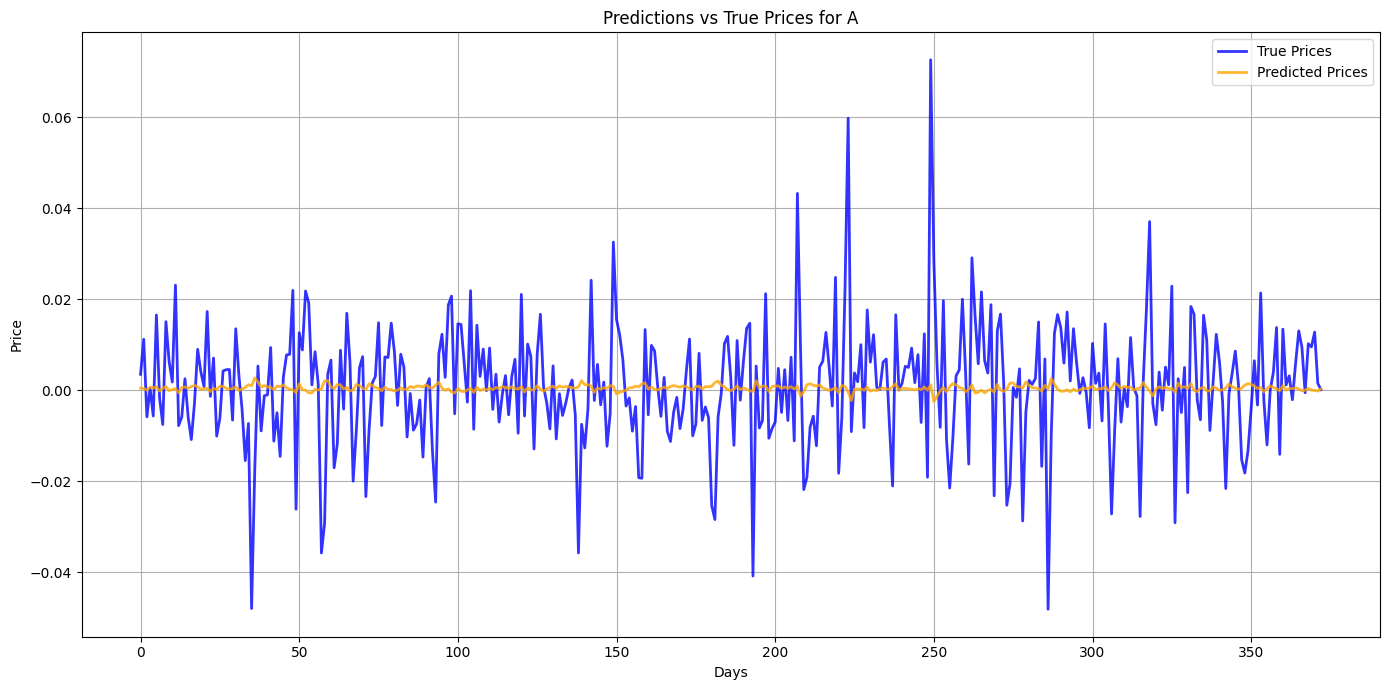

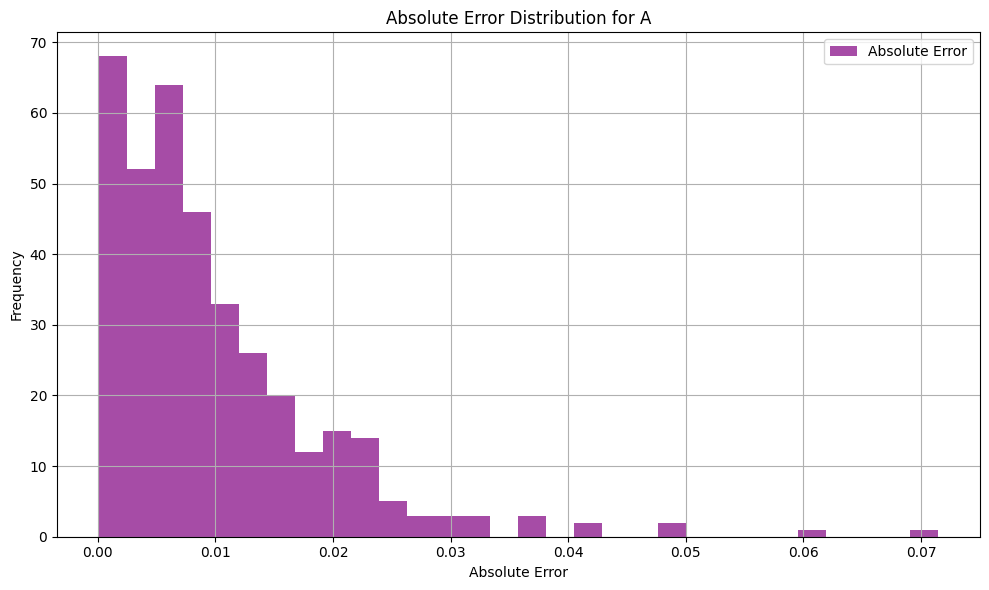

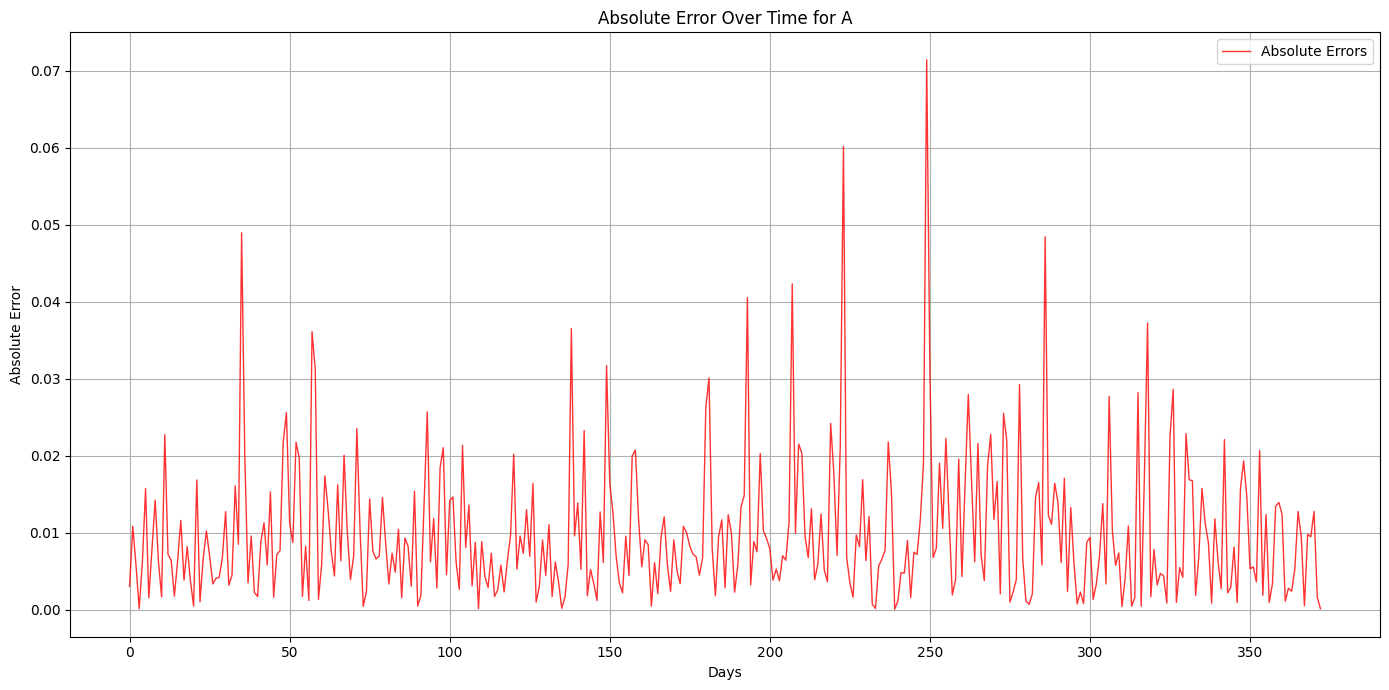

In [26]:
model = LstmRNNEh(stock_count=1, model_type="Bidirectional_LSTM")
model.load()
predictions = model.model.predict(dataset.test_X)
# Visualize and evaluate results
evaluate_and_visualize(predictions.flatten(), dataset.test_y.flatten(), stock_sym=stock_sym)